# Predict Survival from Measured Concentrations

This notebook predicts bacterial survival probabilities from fitted concentration profiles by:
1. Loads HQNO and RHL concentration fit parameters
2. Loads survival model parameters from batch survival experiments
3. Calculates survival probabilities using logistic regression models fitted to exaustive sampling of experimental fit parameters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import sys
import seaborn as sns
sys.path.append(str(Path.cwd().parent / '0_plot_functions'))
from plot_publication_figures import plot_dual_axis_percentiles

def uptake_diffusion_sinh(x, c_max, L, A):
    """
    Calculates numerically stable uptake–diffusion concentration profile, assuming zero boundary condition at x=L.

    Parameters:
    - x: array-like, positions along the gradient
    - c_max: float, maximum concentration at x=0
    - L: float, length of the domain
    - A: float, uptake/diffusion rate [1/m^2]

    Returns:
    - c: array-like, concentration at positions x
    c(x) = c_max * sinh(sqrt(A)*(L - x)) / sinh(sqrt(A)*L)

    """
    sA = np.sqrt(A)
    return c_max * np.sinh(sA * (L - x)) / np.sinh(sA * L)

def inv_logit(z):
    z = np.asarray(z, dtype=float)
    return 1.0 / (1.0 + np.exp(-z))

def predict_survival(conc_h, conc_r, model_params):
    """
    Predict survival probability given concentration and model parameters.
    
    Parameters:
    - conc_h: array-like, concentrations of hqno
    - conc_r: array-like, concentrations of rhl
    - model_params: dict, parameters of the logistic regression model with keys 'm_rhl', 'm_hqno', and 'b'
    
    Returns:`
    - survival_probs: array-like, predicted survival probabilities
    """

    m_rhl  = float(model_params["m_rhl"])
    m_hqno = float(model_params["m_hqno"])
    b      = float(model_params["b"])

    rz = m_rhl  * conc_r  + m_hqno * conc_h + b
    survival_probs = inv_logit(rz)
    
    return survival_probs

def create_concentration_profile(df, x_vals):
    """
    Generate concentration profiles for all replicates at specified x positions.
    
    Parameters:
    - df: DataFrame containing fit parameters (c_max, L, A) and unique_id
    - x_vals: array-like, positions along the gradient where concentrations are calculated
    
    Returns:
    - conc_profiles: DataFrame with columns 'unique_id', 'x', and 'concentration'
    """
    conc_profiles_list = []
    for _, row in df.iterrows():
        unique_id = row['unique_id']
        c_max = row['c_max']
        L = row['L']
        A = row['A']
        c_x = uptake_diffusion_sinh(x_vals, c_max, L, A)
        conc_profile = {
            'unique_id': unique_id,
            'y_um': x_vals,
            'concentration': c_x,
        }
        conc_profiles_list.append(conc_profile)

    conc_profiles = pd.DataFrame(conc_profiles_list).explode(['y_um', 'concentration']).reset_index(drop=True)
    return conc_profiles

def survival_from_par(diffusion_params, model_params, L=50, x_vals=np.linspace(0, 50, 100)):
    """
    Calculate survival probabilities along a gradient given fit parameters and model parameters.
    
    Parameters:
    - diffusion_params: dict, parameters for the diffusion model with keys 'c_max_h', 'A_h', 'c_max_r', and 'A_r'
    - model_params: dict, parameters of the logistic regression model with keys 'm_rhl', 'm_hqno', and 'b'
    - L: float, length of the domain (default 50 um)
    - x_vals: array-like, positions along the gradient where concentrations are calculated
    
    Returns:
    - survival_probs: array-like, predicted survival probabilities at positions x_vals
    """
    conc_profile_h = uptake_diffusion_sinh(x_vals, diffusion_params['c_max_h'], L, diffusion_params['A_h'])
    conc_profile_r = uptake_diffusion_sinh(x_vals, diffusion_params['c_max_r'], L, diffusion_params['A_r'])
    survival_probs = predict_survival(conc_profile_h, conc_profile_r, model_params)
    return survival_probs

In [22]:
# Paths to data files

df_h_legacy = pd.read_csv(Path.cwd().parent / '2_gradient_inference_legacy' / 'data' / '2_hqno_diffusion_model_fits_legacy.csv')
df_h_spline = pd.read_csv(Path.cwd().parent / '2_gradient_inference_altbg' / 'data' / '2_hqno_diffusion_model_fits_hybrid.csv')
df_h_hill = pd.read_csv(Path.cwd().parent / '2_gradient_inference_altbg' / 'data' / '2_hqno_diffusion_model_fits_hill.csv')

# Drop replicate_4 from HQNO dataframes
df_h_legacy = df_h_legacy[df_h_legacy['replicate'] != 'replicate_4'].reset_index(drop=True)
df_h_spline = df_h_spline[df_h_spline['replicate'] != 'replicate_4'].reset_index(drop=True)
df_h_hill = df_h_hill[df_h_hill['replicate'] != 'replicate_4'].reset_index(drop=True)

df_r_legacy = pd.read_csv(Path.cwd().parent / '2_gradient_inference_legacy' / 'data' / '2_rhl_diffusion_model_fits_legacy.csv')
df_r_spline = pd.read_csv(Path.cwd().parent / '2_gradient_inference_altbg' / 'data' / '2_rhl_diffusion_model_fits_hybrid.csv')
df_r_hill = pd.read_csv(Path.cwd().parent / '2_gradient_inference_altbg' / 'data' / '2_rhl_diffusion_model_fits_hill.csv')


datasets = {'legacy': (df_h_legacy, df_r_legacy),
            'spline': (df_h_spline, df_r_spline),
            'hill': (df_h_hill, df_r_hill)}

SURVIVAL_JSON_legacy = Path.cwd().parent / '3_batch_survival' / 'data' / 'survival_model_parameters_legacy.json'
SURVIVAL_JSON = Path.cwd().parent / '3_batch_survival' / 'data' / 'survival_model_parameters.json'

# Load linear params
with open(SURVIVAL_JSON, "r", encoding="utf-8") as f:
    cfg_clipped = json.load(f)

with open(SURVIVAL_JSON_legacy, "r", encoding="utf-8") as f:
    cfg_norm = json.load(f)

cfg = {'clipped': cfg_clipped['hqno_max_80'], 'normalized': cfg_norm['hqno_max_80']}
survival_models = cfg.keys()

# ——— figure style ———
final_width_cm = 8    # width in cm
final_height_cm = 5   # height in cm
final_width_in = final_width_cm / 2.54
final_height_in = final_height_cm / 2.54
font_size = 8  # points
plt.rcParams.update({
    'font.size': font_size,
    'font.family': 'Arial',
    'axes.labelsize': font_size,
    'axes.titlesize': font_size,
    'xtick.labelsize': font_size,
    'ytick.labelsize': font_size,
    'legend.fontsize': font_size,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# HQNO color (green)
hqno_color = '#669966'

# RHL color (purple)
rhl_color = '#cc99ff'

# --- Load data ---
outcome_combined = {}

simmulation = {}

for dataset_key in datasets:
    df_hqno_fit, df_rhl_fit = datasets[dataset_key]
    # Create unique IDs
    df_hqno_fit['unique_id'] = df_hqno_fit['replicate'].astype(str) + '_' + df_hqno_fit['pos'].astype(str)
    df_rhl_fit['unique_id'] = df_rhl_fit['replicate'].astype(str) + '_' + df_rhl_fit['pos'].astype(str)

    # Generate high-resolution fitted curves for plotting
    y_fit = np.linspace(0, 45, 181)
    df_hqno = create_concentration_profile(df_hqno_fit, y_fit)
    df_rhl = create_concentration_profile(df_rhl_fit, y_fit)


    # --- Predict survival probabilities directly from measured concentrations ---

    n_rep_h = len(df_hqno['unique_id'].unique())
    n_rep_r = len(df_rhl['unique_id'].unique())
    pred_survival = []

    simmulation[dataset_key] = {}


    for model in survival_models:
        print('units of measured parameters:', cfg[model]['units'])

        outcome_model = {'model': model, 'dataset': dataset_key}
        # Calculate survival probabilities using empirical sampling of concentration profiles to estimate variability
        survival_prob = np.zeros((n_rep_h*n_rep_r, len(y_fit)))
        idx = 0

        simmulation[dataset_key][model] = {}

        for i in range(n_rep_h):
            for j in range(n_rep_r):

                
                conc_hqno = df_hqno[df_hqno['unique_id'] == df_hqno['unique_id'].unique()[i]][ 'concentration'].values
                conc_rhl = df_rhl[df_rhl['unique_id'] == df_rhl['unique_id'].unique()[j]][ 'concentration'].values

                uni_id = f"{df_hqno['unique_id'].unique()[i]}_{df_rhl['unique_id'].unique()[j]}"

                simmulation[dataset_key][model][uni_id] = {}

                y_hqno = df_hqno[df_hqno['unique_id'] == df_hqno['unique_id'].unique()[i]][ 'y_um'].values
                y_rhl = df_rhl[df_rhl['unique_id'] == df_rhl['unique_id'].unique()[j]][ 'y_um'].values

                if not np.array_equal(y_hqno, y_rhl) or len(y_hqno) == 0 or len(y_rhl) == 0:
                    raise ValueError('y positions of hqno and rhl do not match!')

                survival_prob_values = predict_survival(conc_hqno, conc_rhl, cfg[model]['parameters'])
                survival_prob[idx, :] = survival_prob_values
                simmulation[dataset_key][model][uni_id]['survival_prob'] = survival_prob_values  
                simmulation[dataset_key][model][uni_id]['y_um'] = y_hqno  
                idx += 1

        
            
        outcome_model['median_over_simulations'] = np.median(survival_prob, axis=0)


        diffusion_params_median = {
            'c_max_h': np.median(df_hqno_fit['c_max'].values),
            'A_h': np.median(df_hqno_fit['A'].values),
            'c_max_r': np.median(df_rhl_fit['c_max'].values),
            'A_r': np.median(df_rhl_fit['A'].values),
        }

        diffusion_params_median_over_median = {
            'c_max_h': np.median(df_hqno_fit.groupby('replicate')['c_max'].median().values),
            'A_h': np.median(df_hqno_fit.groupby('replicate')['A'].median().values),
            'c_max_r': np.median(df_rhl_fit.groupby('replicate')['c_max'].median().values),
            'A_r': np.median(df_rhl_fit.groupby('replicate')['A'].median().values),
        }   

        outcome_model['median_of_parameters'] = survival_from_par(diffusion_params_median, cfg[model]['parameters'], L=50, x_vals=y_fit)
        outcome_model['median_of_median_parameters'] = survival_from_par(diffusion_params_median_over_median, cfg[model]['parameters'], L=50, x_vals=y_fit)

        outcome_combined[model] = outcome_model
            


units of measured parameters: {'Rhamnolipids': 'µg/ml', 'HQNO': 'ng/ml'}
units of measured parameters: {'Rhamnolipids': 'µg/ml', 'HQNO': 'ng/ml'}
units of measured parameters: {'Rhamnolipids': 'µg/ml', 'HQNO': 'ng/ml'}
units of measured parameters: {'Rhamnolipids': 'µg/ml', 'HQNO': 'ng/ml'}
units of measured parameters: {'Rhamnolipids': 'µg/ml', 'HQNO': 'ng/ml'}
units of measured parameters: {'Rhamnolipids': 'µg/ml', 'HQNO': 'ng/ml'}


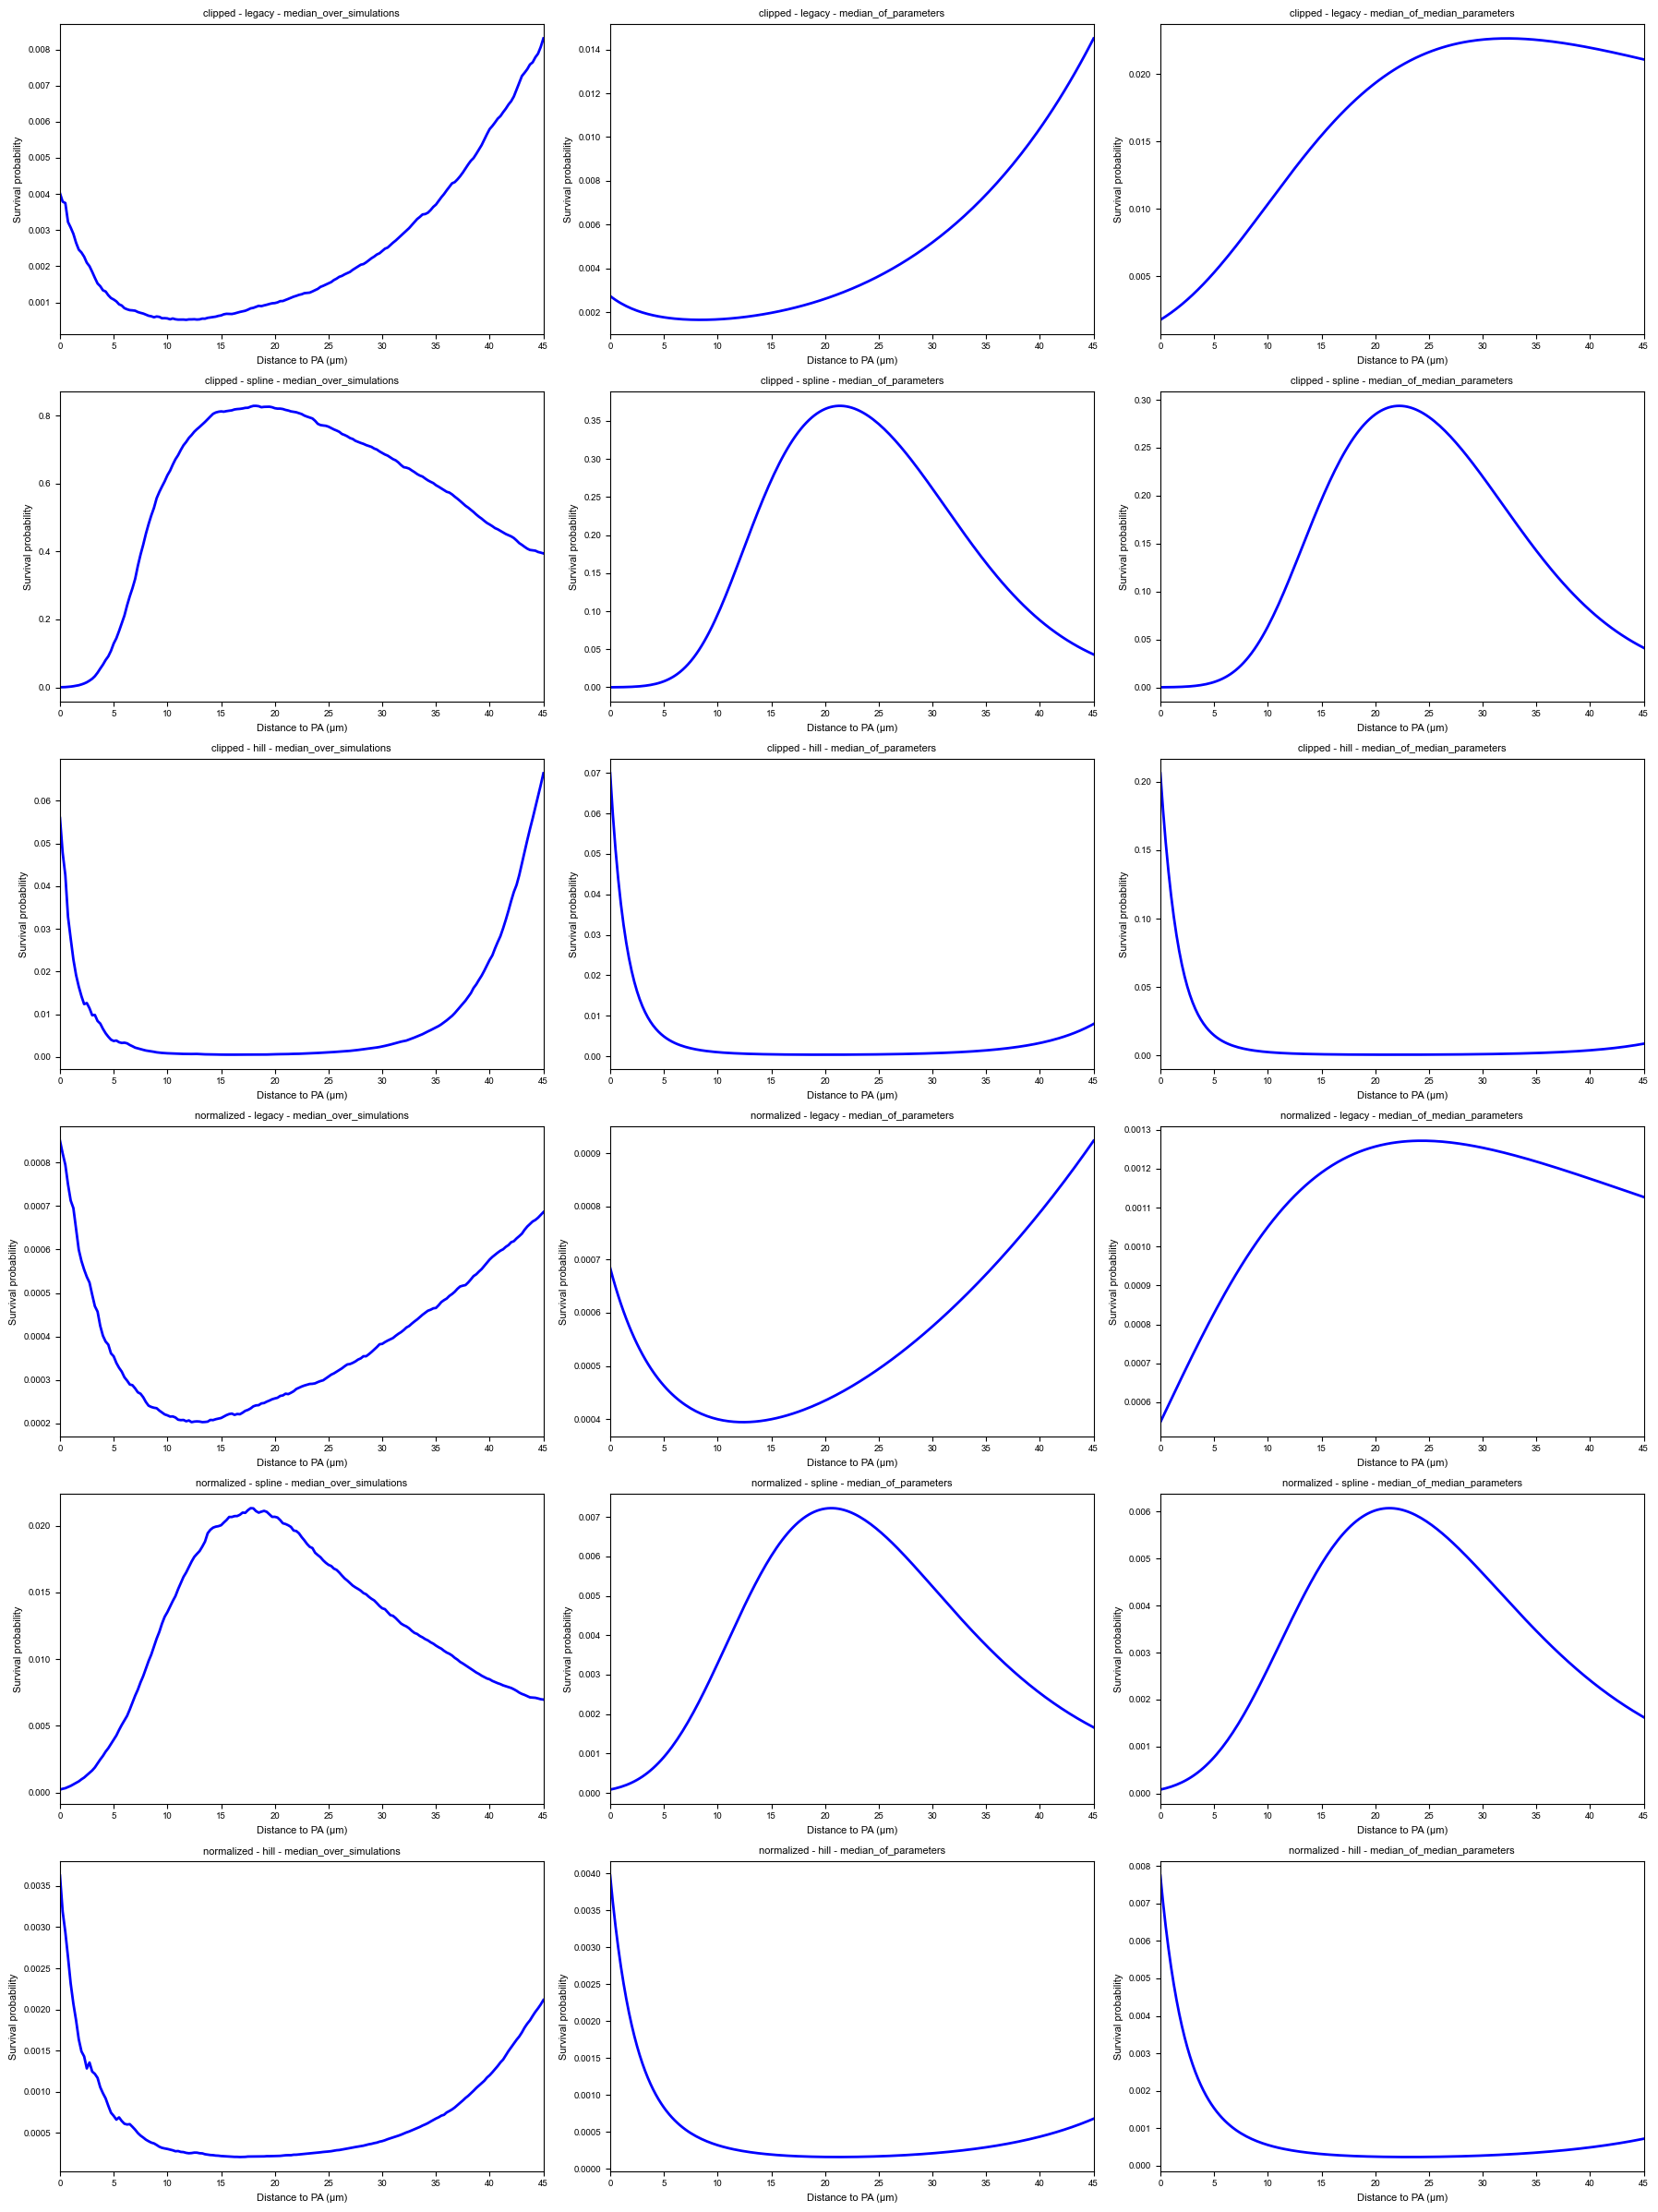

In [3]:
# Create a comprehensive plot showing all model-dataset combinations
datasets_list = list(datasets.keys())
n_models = len(survival_models)
n_datasets = len(datasets_list)
n_outcomes = 3  # median_over_simulations, median_of_parameters, median_of_median_parameters

fig, axs = plt.subplots(n_models * n_datasets, n_outcomes, figsize=(18, 4 * n_models * n_datasets))

# Ensure axs is always 2D
if n_models * n_datasets == 1:
    axs = axs.reshape(1, -1)
elif n_outcomes == 1:
    axs = axs.reshape(-1, 1)

plot_idx = 0
for model in survival_models:
    for dataset in datasets_list:
        # Get the outcome data for this model-dataset combination
        # We need to recalculate for each dataset since outcome_combined only has the last dataset
        df_hqno_fit, df_rhl_fit = datasets[dataset]
        df_hqno_fit['unique_id'] = df_hqno_fit['replicate'].astype(str) + '_' + df_hqno_fit['pos'].astype(str)
        df_rhl_fit['unique_id'] = df_rhl_fit['replicate'].astype(str) + '_' + df_rhl_fit['pos'].astype(str)
        
        # Generate concentration profiles for this dataset
        df_hqno_dataset = create_concentration_profile(df_hqno_fit, y_fit)
        df_rhl_dataset = create_concentration_profile(df_rhl_fit, y_fit)
        
        # Calculate survival for this model-dataset combination
        n_rep_h = len(df_hqno_dataset['unique_id'].unique())
        n_rep_r = len(df_rhl_dataset['unique_id'].unique())
        survival_prob = np.zeros((n_rep_h * n_rep_r, len(y_fit)))
        
        idx = 0
        for i in range(n_rep_h):
            for j in range(n_rep_r):
                conc_hqno = df_hqno_dataset[df_hqno_dataset['unique_id'] == df_hqno_dataset['unique_id'].unique()[i]]['concentration'].values
                conc_rhl = df_rhl_dataset[df_rhl_dataset['unique_id'] == df_rhl_dataset['unique_id'].unique()[j]]['concentration'].values
                
                survival_prob_values = predict_survival(conc_hqno, conc_rhl, cfg[model]['parameters'])
                survival_prob[idx, :] = survival_prob_values
                idx += 1
        
        # Calculate the three outcome measures
        outcomes = {
            'median_over_simulations': np.median(survival_prob, axis=0),
            'median_of_parameters': survival_from_par({
                'c_max_h': np.median(df_hqno_fit['c_max'].values),
                'A_h': np.median(df_hqno_fit['A'].values),
                'c_max_r': np.median(df_rhl_fit['c_max'].values),
                'A_r': np.median(df_rhl_fit['A'].values),
            }, cfg[model]['parameters'], L=50, x_vals=y_fit),
            'median_of_median_parameters': survival_from_par({
                'c_max_h': np.median(df_hqno_fit.groupby('replicate')['c_max'].median().values),
                'A_h': np.median(df_hqno_fit.groupby('replicate')['A'].median().values),
                'c_max_r': np.median(df_rhl_fit.groupby('replicate')['c_max'].median().values),
                'A_r': np.median(df_rhl_fit.groupby('replicate')['A'].median().values),
            }, cfg[model]['parameters'], L=50, x_vals=y_fit)
        }
        
        # Plot each outcome measure
        for col_idx, (outcome_name, values) in enumerate(outcomes.items()):
            ax = axs[plot_idx, col_idx]
            ax.plot(y_fit, values, linewidth=2, color='blue')
            ax.set_title(f'{model} - {dataset} - {outcome_name}', fontsize=8)
            ax.set_xlabel('Distance to PA (µm)', fontsize=8)
            ax.set_ylabel('Survival probability', fontsize=8)
            ax.set_xlim(0, 45)
            ax.tick_params(labelsize=7)
            
        plot_idx += 1

plt.tight_layout()
plt.show()
        

Given low measured concentration range of HQNO, we proceed with model fitted in lowest range

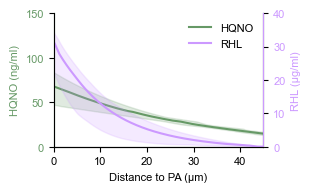

[info] Plotted HQNO (left axis) and RHL (right axis) with percentile bands


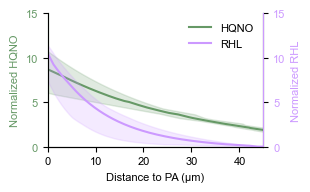

[info] Plotted HQNO (left axis) and RHL (right axis) with percentile bands


In [25]:
model = 'normalized'  # Given low measured concentration range of HQNO, we proceed with model fitted in lowest range

y_fit = np.linspace(0, 45, 181)
df_hqno = create_concentration_profile(df_h_spline, y_fit)
df_rhl = create_concentration_profile(df_r_spline, y_fit)

df_survival = pd.DataFrame(simmulation['spline']['normalized']).T
df_survival = df_survival.reset_index().rename(columns={'index': 'unique_id'})
df_survival = df_survival.explode(['y_um', 'survival_prob']).reset_index(drop=True)

# --- Plot measured concentration gradients ---
left_data = [{
    'df': df_hqno,
    'y_col': 'concentration',
    'label': 'HQNO',
    'color': hqno_color,
    'ylabel': 'HQNO (ng/ml)',
    'ylim': (0, 150),
    'yticks': np.linspace(0, 150, 4)
}]

right_data = [{
    'df': df_rhl,
    'y_col': 'concentration',
    'label': 'RHL',
    'color': rhl_color,
    'ylabel': 'RHL (µg/ml)',
    'ylim': (0, 40)
}]

x_config = {
    'xlabel': "Distance to PA (µm)",
    'xlim': (0, 45)
}

fig, ax = plot_dual_axis_percentiles(
    left_axis_data=left_data,
    right_axis_data=right_data,
    x_col='y_um',
    x_config=x_config,
    percentiles=[25, 50, 75],
    figsize=(final_width_in, final_height_in),
    font_size=font_size
)

# Save outputs
plt.savefig(f'./figures/3_fitted_concentrations.pdf', dpi=300, transparent=True)
plt.show()

print(f"[info] Plotted HQNO (left axis) and RHL (right axis) with percentile bands")


# # --- plot predicted survival from conc ---
# df_pred = df_pred_survival[df_pred_survival['model'] == model]

# # --- Plot measured concentration gradients ---
# left_data = [{
#     'df': df_pred,
#     'y_col': 'predicted_survival',
#     'label': 'survival probability',
#     'color': 'grey',
#     'ylabel': 'Probability of survival',
#     'ylim': (0, y_axis[model][0]),
#     'yticks': y_axis[model][1]
# }]


# x_config = {
#     'xlabel': "Distance to PA (µm)",
#     'xlim': (0, 45)
# }

# fig, ax = plot_dual_axis_percentiles(left_axis_data=left_data, 
#                                         x_col='y_um', x_config=x_config, 
#                                         percentiles=[25, 50, 75],   
#                                         figsize=(final_width_in, final_height_in),
#                                         font_size=font_size)


# # Save outputs
# plt.savefig(f'./figures/3_predicted_survival_from_fit.pdf', dpi=300, transparent=True)
# plt.show()

# print(f"[info] Plotted predicted survival ({model} model) with percentile bands")

# --- Plot measured concentration gradients, rescaled with logit model parameters ---

df_hqno['scaled_conc'] = (cfg[model]['parameters']['m_hqno'] * df_hqno['concentration'])
df_rhl['scaled_conc'] = np.abs(cfg[model]['parameters']['m_rhl']) * df_rhl['concentration']



left_data = [{
    'df': df_hqno,
    'y_col': 'scaled_conc',
    'label': 'HQNO',
    'color': hqno_color,
    'ylabel': 'Normalized HQNO',
    'ylim': (0, 15),
    'yticks': np.linspace(0, 15, 4)
}]

right_data = [{
    'df': df_rhl,
    'y_col': 'scaled_conc',
    'label': 'RHL',
    'color': rhl_color,
    'ylabel': 'Normalized RHL',
    'ylim': (0, 15),
    'yticks': np.linspace(0, 15, 4)
}]

x_config = {
    'xlabel': "Distance to PA (µm)",
    'xlim': (0, 45)
}

fig, ax = plot_dual_axis_percentiles(
    left_axis_data=left_data,
    right_axis_data=right_data,
    x_col='y_um',
    x_config=x_config,
    percentiles=[25, 50, 75],
    figsize=(final_width_in, final_height_in),
    font_size=font_size
)

# Save outputs
plt.savefig(f'./figures/3_fitted_normalized_concentrations.pdf', dpi=300, transparent=True)
plt.show()

print(f"[info] Plotted HQNO (left axis) and RHL (right axis) with percentile bands")



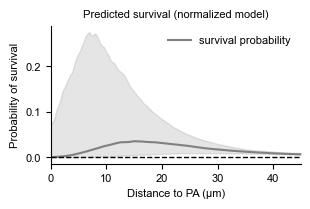

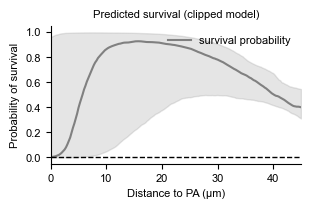

In [27]:
model_list = ['normalized', 'clipped']  # Given low measured concentration range of HQNO, we proceed with model fitted in lowest range

y_fit = np.linspace(0, 45, 181)
df_hqno = create_concentration_profile(df_h_spline, y_fit)
df_rhl = create_concentration_profile(df_r_spline, y_fit)

for model in model_list:
    df_survival = pd.DataFrame(simmulation['spline'][model]).T
    df_survival = df_survival.reset_index().rename(columns={'index': 'unique_id'})
    df_survival = df_survival.explode(['y_um', 'survival_prob']).reset_index(drop=True)


    # --- Plot measured concentration gradients ---
    left_data = [{
        'df': df_survival,
        'y_col': 'survival_prob',
        'label': 'survival probability',
        'color': 'grey',
        'ylabel': 'Probability of survival',

    }]


    x_config = {
        'xlabel': "Distance to PA (µm)",
        'xlim': (0, 45)
    }

    fig, ax = plot_dual_axis_percentiles(left_axis_data=left_data, 
                                            x_col='y_um', x_config=x_config, 
                                            percentiles=[25, 50, 75],   
                                            figsize=(final_width_in, final_height_in),
                                            font_size=font_size)

    ax.set_title(f'Predicted survival ({model} model)', fontsize=font_size)
    ax.hlines(0, xmin=0, xmax=45, colors='black', linestyles='dashed', linewidth=1)
    # Show outputs
    plt.show()
